# Predict Ethereum Close Price

* https://www.crosstab.io/articles/time-series-pytorch-lstm
* https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

import pytorch_common.util    as pu
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel

from pytorch_common.callbacks.output import OutputHook

from pytorch_common.modules import PredictMixin, FitMixin


from data   import SequenceDataset, \
                   standarizer, \
                   variable_to_sequences, \
                   features_target_split, \
                   train_test_split
from util   import set_seed, \
                   loss_wrapper

from module import TimeSeriesPredictor

In [4]:
def plot(y_pred, y_true, times=100):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})

In [11]:
set_seed(42)

In [12]:
WINDOW_SIZE = 200
TARGET_SIZE = 150
N_WORKERS   = 24
BATCH_SIZE  = 200
VARIABLE    = 'close'
TRAIN       = True

In [13]:
DATASET_PATH = '../datasets/ETH_1H.csv'
WEIGHTS_PATH = '../weights'

## Preprocessing

#### 1. Load dataset.

In [14]:
df = pd.read_csv(DATASET_PATH)
df.columns = df.columns.str.lower()
df.columns

Index(['unix timestamp', 'date', 'symbol', 'open', 'high', 'low', 'close',
       'volume'],
      dtype='object')

In [15]:
dataset = df[['date', VARIABLE]]
dataset.head()

,date,close
0,2020-04-16 00:00:00,150.39
1,2020-04-15 23:00:00,152.94
2,2020-04-15 22:00:00,155.81
3,2020-04-15 21:00:00,157.18
4,2020-04-15 20:00:00,158.04


In [16]:
dataset.shape

(34497, 2)

#### 2. Train-test splot and normalize data:

In [17]:
train_set,      test_set      = train_test_split(dataset, test_percent = 0.8)

norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=[VARIABLE])

# norm_train_set = train_set.copy()
# norm_test_set = test_set.copy()
# norm_train_set[f'norm_{VARIABLE}'] = norm_train_set[VARIABLE]
# norm_train_set[f'norm_{VARIABLE}']  = norm_train_set[VARIABLE]

train_set.shape, test_set.shape

((6900, 2), (27598, 2))

In [18]:
norm_train_set['norm_close'] = norm_train_set['norm_close'].apply(lambda x: round(x, 4))
norm_test_set['norm_close'] = norm_train_set['norm_close'].apply(lambda x: round(x, 4))

In [19]:
norm_train_set.head()

,date,close,norm_close
0,2020-04-16 00:00:00,150.39,-0.7995
1,2020-04-15 23:00:00,152.94,-0.7381
2,2020-04-15 22:00:00,155.81,-0.6689
3,2020-04-15 21:00:00,157.18,-0.6359
4,2020-04-15 20:00:00,158.04,-0.6152


#### 3. Separare into sequences using a sliding window.

In [20]:
variable_norm_values = norm_train_set[f'norm_{VARIABLE}']

train_set_sequences = variable_to_sequences(variable_norm_values, WINDOW_SIZE)
test_set_sequences  = variable_to_sequences(variable_norm_values,  WINDOW_SIZE)

train_set_sequences.shape, test_set_sequences.shape

((6701, 200), (6701, 200))

#### 4. Separate sequences into (features=sequence-1, target=last):

In [21]:
train_features, train_targets = features_target_split(train_set_sequences, target_size=TARGET_SIZE)
test_features,  test_targets  = features_target_split(test_set_sequences, target_size=TARGET_SIZE)

train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((6701, 50), (6701, 150), (6701, 50), (6701, 150))

In [22]:
torch.tensor(train_features).unsqueeze(2).float().shape

torch.Size([6701, 50, 1])

#### 5. Create a dataset for both train an test sets:

In [23]:
train_dataset = SequenceDataset(train_features, train_targets)
test_dataset  = SequenceDataset(test_features, test_targets)

len(train_dataset), len(test_dataset)

(6701, 6701)

In [24]:
f, t = train_dataset[0]
f.shape, t.shape

(torch.Size([50, 1]), torch.Size([150]))

In [25]:
f, t = test_dataset[0]
f.shape, t.shape

(torch.Size([50, 1]), torch.Size([150]))

#### 6. Create dataloader for both tra and test datasets:

In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

f, t = next(iter(train_loader))
f.shape, t.shape

(torch.Size([200, 50, 1]), torch.Size([200, 150]))

In [27]:
f, t = next(iter(test_loader))
f.shape, t.shape

(torch.Size([200, 50, 1]), torch.Size([200, 150]))

# Model Definition

In [28]:
from torch import nn

class TimeSeriesPredictor(nn.Module, PredictMixin, FitMixin):
    def __init__(self, input_size, n_hidden_units, n_layers=2, dropout=0.2, out_features=20):
        super().__init__()
        self.n_layers       = n_layers
        self.n_hidden_units = n_hidden_units
        self.rnn = nn.LSTM(
            input_size  = input_size,
            hidden_size = self.n_hidden_units,
            batch_first = True,
            dropout     = dropout,
            num_layers  = self.n_layers
        )
        self.linear = nn.Linear(
            in_features  = self.n_hidden_units,
            out_features = out_features
        )

    def forward(self, input_batch):

        batch_size = input_batch.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden_units).requires_grad_().to(self.device)

        _, (hidden, c_) = self.rnn(input_batch.to(self.device), (h0, c0))
        return self.linear(hidden[-1]).squeeze(1)

In [29]:
n_hidden_units = 50
sequence_size  = WINDOW_SIZE -1
n_epochs       = 100
n_layers       = 5
dropout        = 0
total_samples  = len(train_dataset)
out_features   = TARGET_SIZE


model = TimeSeriesPredictor(
    input_size     = 1, 
    n_hidden_units = n_hidden_units, 
    n_layers       = n_layers,
    dropout        = dropout,
    out_features   = out_features
).to(pu.get_device())

model

TimeSeriesPredictor(
  (rnn): LSTM(1, 50, num_layers=5, batch_first=True)
  (linear): Linear(in_features=50, out_features=150, bias=True)
)

In [30]:
f, t = next(iter(test_loader))
f.shape, model(f).shape

(torch.Size([200, 50, 1]), torch.Size([200, 150]))

# Train

In [31]:
def interpolation_plot(time=100):
    feature, _  = test_dataset[0]
    complete_pred_values = feature.squeeze(1).tolist()

    pred_values, true_values = [], []

    for time in range(1, 100+1):
        features = complete_pred_values[-sequence_size:]

        input    = torch.tensor(features).unsqueeze(1).unsqueeze(0)

        next_values  = model.predict(input).squeeze(0).cpu().numpy()

        complete_pred_values.append(next_values[0])

        pred_values.append(next_values[0])

        _, y_trues = test_dataset[time]
        true_values.append(y_trues[0])

    plot(pred_values, true_values)

<Figure size 576x288 with 1 Axes>

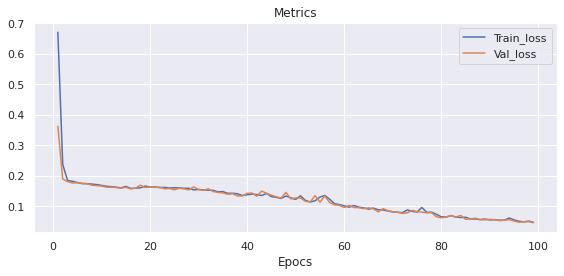

<Figure size 576x288 with 1 Axes>

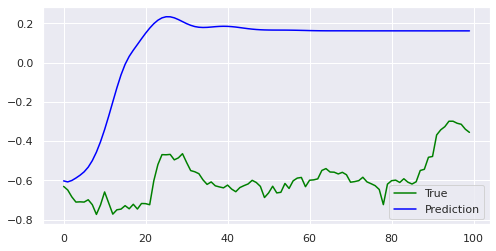

In [33]:
if TRAIN:
    sns.set(rc = {'figure.figsize':(8,4)})

    learning_rate  = 0.001

    loss_fn = MSELoss()

    model.fit(
        train_loader,
        loss_fn   = loss_fn,
        epochs    = n_epochs,
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr = learning_rate
        ),
        callbacks   = [
            Validation(
                test_loader,
                metrics       = { 'val_loss': loss_wrapper(loss_fn) },
                each_n_epochs = 1
            ),
            Logger(['time', 'epoch', 'train_loss', 'val_loss']),
            MetricsPlotter(metrics=['train_loss', 'val_loss'],  plot_each_n_epochs=5),
            OutputHook(lambda ctx: interpolation_plot(), plot_each_n_epochs=5)
            #, SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='lstm-time-series')
        ]
    )

In [ ]:
# PATH = f'{WEIGHTS_PATH}/2022-08-12_17-42-45--lstm-time-series--epoch_18--val_loss_0.0001459738559788093.pt'
# model.load_state_dict(torch.load(PATH))

In [ ]:
from prophet import Prophet